In [38]:
%matplotlib inline
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


In [10]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')




In [11]:
categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

In [12]:
remove = ()

In [26]:
print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')
# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded


In [27]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories



In [28]:
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()

Extracting features from the training data using a sparse vectorizer


In [32]:
n_features = 2 ** 16
#vectorizer = HashingVectorizer(stop_words='english', non_negative=True,n_features=n_features)
#X_train = vectorizer.transform(data_train.data)

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)

In [33]:
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

done in 535.641480s at 0.007MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.438683s at 6.537MB/s
n_samples: 1353, n_features: 33809



In [34]:
feature_names = None

In [35]:
feature_names = vectorizer.get_feature_names()

In [36]:
if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [43]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if False and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if True:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)



Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.204s
test time:  0.002s
accuracy:   0.896
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.90      0.98      0.94       389
         sci.space       0.96      0.94      0.95       394
talk.religion.misc       0.83      0.78      0.80       251

       avg / total       0.89      0.90      0.89      1353

confusion matrix:
[[265  10   7  37]
 [  1 381   4   3]
 [  0  23 371   0]
 [ 40  10   6 195]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.114s
test time:  0.002s
accuracy:   0.885
dimensionality: 33809
density: 0.240165

classification report:
                  

/usr/local/lib/python3.6/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.154s
test time:  0.001s
accuracy:   0.900
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.91      0.98      0.95       389
         sci.space       0.96      0.95      0.95       394
talk.religion.misc       0.83      0.79      0.81       251

       avg / total       0.90      0.90      0.90      1353

confusion matrix:
[[266   7   8  38]
 [  2 381   3   3]
 [  1  20 373   0]
 [ 38   9   6 198]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.133s
test time:  0

/usr/local/lib/python3.6/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.266s
test time:  0.002s
accuracy:   0.873
dimensionality: 33809
density: 0.005561

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.85      0.75      0.80       319
     comp.graphics       0.89      0.97      0.93       389
         sci.space       0.94      0.94      0.94       394
talk.religion.misc       0.76      0.78      0.77       251

       avg / total       0.87      0.87      0.87      1353

confusion matrix:
[[238  14  11  56]
 [  0 378   7   4]
 [  2  22 369   1]
 [ 39  12   4 196]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.366s
test time:  0

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


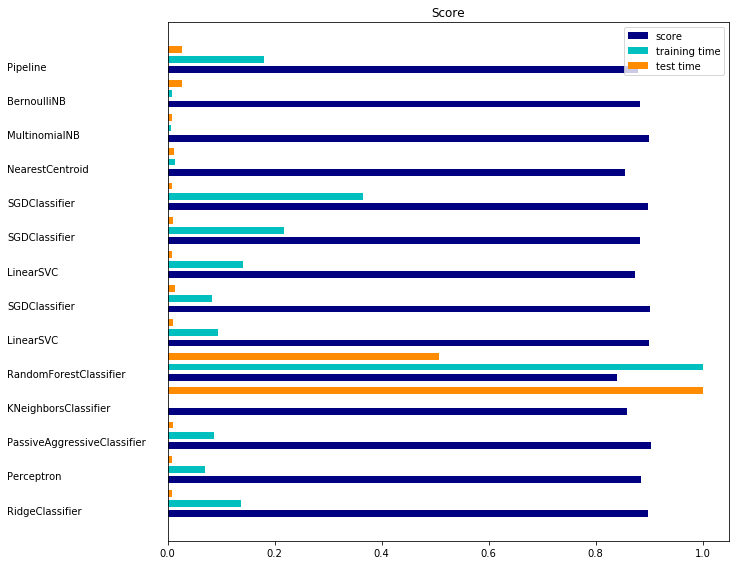

In [42]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
